In [1]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None, close_fig=True):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    if close_fig:
        plt.close(fig)
        

# def maskedarray_gt(data, value):
#     """ Greater than operation on masked array to avoid warning errors """
#     data = np.nan_to_num(data,0)
#     data[data > value] = value
#     return data


# def maskedarray_lt(data, value):
#     """ Less than operation on masked array to avoid warning errors """
#     data = np.nan_to_num(data,0)
#     data[data < value] = value
#     return data


# def ts_fromdebris_func(h, a, b, c):
#         """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#         Hill Equation"""
#         return a * h**c / (b**c + h**c)
# def debris_fromts_func(ts, a, b, c):
#     """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
#     Hill Equation"""
#     return (ts * b**c / (a - ts))**(1/c)

# def meltfactor_fromdebris_func(h, a, k, melt_2cm):
#     """ estimate melt factor from debris thickness (h is debris thickness, a and k are coefficients) 
#     Hill equation """
#     melt_h = a / (1 + 2 * k * a * h)
#     melt_factor = melt_h / melt_2cm
#     melt_factor[melt_factor > 1] = 1
#     return melt_factor

# def debris_fromts_maskedarray(ts_raw, a, b, c):
#     """ Apply debris_fromts_func to masked array
#         includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
#     Parameters
#     ----------
#     ts_raw : np.ma.array
#         masked array of the unmodified surface temperature
#     Returns
#     -------
#     hd : np.ma.array 
#         masked array of the debris thickness (m)
#     """
#     ts = ts_raw.copy()
#     max_value = ts_fromdebris_func(50, a, b, c)
#     debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
#     debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
#     hd = debris_fromts_func(ts.data, a, b, c)
#     return hd


# def emergence_pixels(gf, vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
#                      vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
#                      positive_is_east=True, positive_is_north=True, constant_icethickness=False, debug=True):
#     """ Compute the emergence velocity using an ice flux approach
#     """
#     # Glacier mask
#     glac_mask = np.zeros(vel_x_raw.shape) + 1
#     glac_mask[gf.z1.mask] = 0
    
#     # Replace nan with 0
#     vel_x_raw = np.nan_to_num(vel_x_raw,0)
#     vel_y_raw = np.nan_to_num(vel_y_raw,0)
    
#     # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
#     #    Specifically, a negative y velocity means the pixel is flowing south.
#     #    However, if you were to subtract that value from the rows, it would head north in the matrix.
#     #    This is due to the fact that the number of rows start at 0 at the top.
#     #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
#     if positive_is_north:
#         vel_y = -1*vel_y_raw * vel_depth_avg_factor
#     else:
#         vel_y = vel_y_raw * vel_depth_avg_factor
#     if positive_is_east:
#         vel_x = vel_x_raw * vel_depth_avg_factor
#     else:
#         vel_x = -1*vel_x_raw * vel_depth_avg_factor
#     vel_total = (vel_y**2 + vel_x**2)**0.5
#     # Ice thickness
#     icethickness = icethickness_raw.copy()
#     if constant_icethickness:
#         icethickness[:,:] = 1
#         icethickness = icethickness * glac_mask
# #     print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
#     # Compute the initial volume
#     volume_initial = icethickness * (xres * yres)
#     pix_maxres = xres
#     if yres > pix_maxres:
#         pix_maxres = yres
#     # Quality control options:
#     # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
#     if option_border == 1:
#         border = int(max_velocity / pix_maxres) + 1
#         for r in range(vel_x.shape[0]):
#             for c in range(vel_x.shape[1]):
#                 if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
#                     vel_x[r,c] = 0
#                     vel_y[r,c] = 0
#     # Minimum/maximum velocity bounds
#     vel_x[vel_total < vel_min] = 0
#     vel_y[vel_total < vel_min] = 0
#     vel_x[vel_total > max_velocity] = 0
#     vel_y[vel_total > max_velocity] = 0
# #     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of cliffs and ponds
# #     if option_stagnantbands == 1:
# #         vel_x[bands <= stagnant_band] = 0
# #         vel_y[bands <= stagnant_band] = 0        
#     # Compute displacement in units of pixels
#     vel_x_pix = vel_x / xres
#     vel_y_pix = vel_y / yres
#     # Compute the displacement and fraction of pixels moved for all columns (x-axis)
#     # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
#     #    int() automatically rounds towards zero
#     col_x1 = vel_x_pix.astype(int)
#     # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
#     #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
#     col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
#     # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) 
#     #    [ex. 2.6 returns 0.6, -2.6 returns 0.6]
#     #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
#     #    then when you take the remainder using "% 1", you obtain the desired fraction
#     rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
#     # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) 
#     #    [ex. 2.6 returns 0.4, -2.6 returns 0.4]
#     rem_x1 = 1 - rem_x2
#     # Repeat the displacement and fraction computations for all rows (y-axis)
#     row_y1 = vel_y_pix.astype(int)
#     row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
#     rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
#     rem_y1 = 1 - rem_y2
          
#     # Compute the mass flux for each pixel
#     volume_final = np.zeros(volume_initial.shape)
#     for r in range(vel_x.shape[0]):
#         for c in range(vel_x.shape[1]):
#             volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
#                 volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
#                 )
#             volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
#                 volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
#                 )
#             volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
#                 volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
#                 )
#             volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
#                 volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
#                 )
         
#     # Redistribute off-glacier volume back onto the nearest pixel on the glacier
#     offglac_row, offglac_col = np.where((glac_mask == 0) & (volume_final > 0))
#     for nidx in range(0,len(offglac_row)):
#         nrow = offglac_row[nidx]
#         ncol = offglac_col[nidx]
#         ridx, cidx = nearest_nonzero_idx(glac_mask, nrow, ncol)
#         # Add off-glacier volume back onto nearest pixel on glacier
#         volume_final[ridx,cidx] += volume_final[nrow,ncol]
#         volume_final[nrow,ncol] = 0
            
#     # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
#     if debug:
#         print('Mass is conserved?', np.absolute(volume_final.sum() - volume_initial.sum()) / 
#               volume_initial.sum() < 0.01)
#         print(np.round(np.absolute(volume_final.sum() - volume_initial.sum()),1), 
#               np.round(np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() * 100,2), '%')
        
#     if np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() > 0.01:
#         print('MASS NOT CONSERVED FOR EMERGENCE VELOCITY')
#     # Final ice thickness
#     icethickness_final = volume_final / (xres * yres)
#     # Emergence velocity
#     emergence_velocity = icethickness_final - icethickness
#     return emergence_velocity

In [2]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import median_absolute_deviation
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib


import debrisglobal.globaldebris_input as debris_prms
from debrisglobal.glacfeat import GlacFeat, create_glacfeat

calc_emergence = True

verbose=False
debug=False
extra_layers=True

csv_ending = '_mb_bins.csv'
# outdir_csv = '/'.join(debris_prms.dhdt_fn_dict[debris_prms.roi].split('/')[:-1]) + '/binned_data/'
outdir_csv = debris_prms.mb_binned_fp
if os.path.exists(outdir_csv) == False:
    os.makedirs(outdir_csv)

In [3]:
# Debris cover extent shapefile with statistics
dc_shp = gpd.read_file(debris_prms.debriscover_fp + debris_prms.debriscover_fn_dict[debris_prms.roi])
dc_shp = dc_shp.sort_values(by=['RGIId'])

# Subset by percent debris-covered or debris-covered area
dc_shp_subset = dc_shp[((dc_shp['DC_Area__1'] > debris_prms.dc_percarea_threshold) | 
                        (dc_shp['DC_Area_v2'] / 1e6 > debris_prms.dc_area_threshold))
                        & (dc_shp['Area'] > debris_prms.min_glac_area)].copy()
dc_shp_subset.reset_index(inplace=True, drop=True)
dc_shp_subset['CenLon_360'] = dc_shp_subset['CenLon']
dc_shp_subset.loc[dc_shp_subset['CenLon_360'] < 0, 'CenLon_360'] = (
    360 + dc_shp_subset.loc[dc_shp_subset['CenLon_360'] < 0, 'CenLon_360'])
print(dc_shp_subset.RGIId.values)
dc_shp_subset

['RGI60-02.00280' 'RGI60-02.00737' 'RGI60-02.00914' 'RGI60-02.01104'
 'RGI60-02.01152' 'RGI60-02.01158' 'RGI60-02.01161' 'RGI60-02.01290'
 'RGI60-02.01291' 'RGI60-02.01297' 'RGI60-02.01339' 'RGI60-02.01397'
 'RGI60-02.01441' 'RGI60-02.01654' 'RGI60-02.01665' 'RGI60-02.01685'
 'RGI60-02.01727' 'RGI60-02.01811' 'RGI60-02.01812' 'RGI60-02.01922'
 'RGI60-02.01923' 'RGI60-02.02107' 'RGI60-02.02348' 'RGI60-02.02360'
 'RGI60-02.02386' 'RGI60-02.02432' 'RGI60-02.02526' 'RGI60-02.02527'
 'RGI60-02.02533' 'RGI60-02.02550' 'RGI60-02.02551' 'RGI60-02.02616'
 'RGI60-02.02636' 'RGI60-02.02686' 'RGI60-02.02745' 'RGI60-02.02747'
 'RGI60-02.02752' 'RGI60-02.02784' 'RGI60-02.02857' 'RGI60-02.02894'
 'RGI60-02.02897' 'RGI60-02.02947' 'RGI60-02.02948' 'RGI60-02.02966'
 'RGI60-02.03099' 'RGI60-02.03102' 'RGI60-02.03157' 'RGI60-02.03520'
 'RGI60-02.03578' 'RGI60-02.03581' 'RGI60-02.03586' 'RGI60-02.03597'
 'RGI60-02.03664' 'RGI60-02.03769' 'RGI60-02.03922' 'RGI60-02.03943'
 'RGI60-02.03963' 'RGI60-02.03995'

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,DC_Area,DC_BgnDate,DC_EndDate,DC_CTSmean,DC_Area_%,area_singl,DC_Area_v2,DC_Area__1,geometry,CenLon_360
0,RGI60-02.00280,G237427E49886N,20049999,20069999,-122.573034,49.882732,2,2,5.938,1671,...,468900,2013,2017,35.192442,7.90,21617,304435,5.127,"MULTIPOLYGON (((-122.60226 49.89003, -122.5997...",237.426966
1,RGI60-02.00737,G243472E50214N,20049999,20069999,-116.530729,50.214035,2,3,5.536,2237,...,450900,2013,2017,38.927991,8.14,288223,288223,5.206,"POLYGON ((-116.53549 50.23111, -116.53339 50.2...",243.469271
2,RGI60-02.00914,G236143E50316N,20049999,20069999,-123.854172,50.314732,2,2,4.372,1056,...,873900,2013,2017,16.054972,19.99,28820,784568,17.945,"MULTIPOLYGON (((-123.86658 50.31353, -123.8657...",236.145828
3,RGI60-02.01104,G237395E50420N,20049999,20069999,-122.607486,50.418684,2,2,3.016,1850,...,269100,2013,2017,35.039186,8.92,169332,169332,5.614,"POLYGON ((-122.60957 50.43131, -122.60957 50.4...",237.392514
4,RGI60-02.01152,G236110E50341N,20049999,20069999,-123.869526,50.360763,2,2,12.021,1280,...,1129500,2013,2017,20.501797,9.40,517865,680881,5.664,"MULTIPOLYGON (((-123.87865 50.35121, -123.8778...",236.130474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,RGI60-02.18765,G238984E48311N,19589999,-9999999,-121.017198,48.311120,2,4,4.845,1523,...,554400,2013,2017,59.437023,11.44,103528,485905,10.029,"MULTIPOLYGON (((-121.00731 48.31688, -121.0069...",238.982802
215,RGI60-02.18770,G238996E48072N,19849999,-9999999,-121.003616,48.073581,2,4,2.125,1845,...,265500,2013,2017,59.737753,12.49,32408,114329,5.380,"MULTIPOLYGON (((-121.00635 48.07096, -121.0059...",238.996384
216,RGI60-02.18778,G238943E48357N,19589999,-9999999,-121.057928,48.354310,2,4,2.924,1613,...,879300,2013,2017,56.691099,30.07,805510,805510,27.548,"POLYGON ((-121.06724 48.35866, -121.06683 48.3...",238.942072
217,RGI60-02.18805,G250362E43173N,19669999,-9999999,-109.639270,43.172392,2,5,3.061,3328,...,766800,2013,2017,23.246983,25.05,695596,695596,22.724,"POLYGON ((-109.64516 43.17897, -109.64515 43.1...",250.360730


In [4]:
rgiid_list = [x.split('-')[1] for x in dc_shp_subset['RGIId'].values]
main_glac_rgi_subset = debris_prms.selectglaciersrgitable(rgiid_list)
main_glac_rgi_subset

219 glaciers in region 2 are included in this model run: ['00280', '00737', '00914', '01104', '01152', '01158', '01161', '01290', '01291', '01297', '01339', '01397', '01441', '01654', '01665', '01685', '01727', '01811', '01812', '01922', '01923', '02107', '02348', '02360', '02386', '02432', '02526', '02527', '02533', '02550', '02551', '02616', '02636', '02686', '02745', '02747', '02752', '02784', '02857', '02894', '02897', '02947', '02948', '02966', '03099', '03102', '03157', '03520', '03578', '03581'] and more
This study is focusing on 219 glaciers in region [2]


,O1Index,RGIId,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,Zmed,Slope,Aspect,Lmax,Form,TermType,Surging,RefDate,glacno,rgino_str,RGIId_float
GlacNo,,,,,,,,,,,,,,,,,,,,
0,279,RGI60-02.00280,-122.57300,49.88620,2,2,5.938,1671,2340,1949,14.2,31,4652,0,0,0,20059999,280,02.00280,2.00280
1,736,RGI60-02.00737,-116.52800,50.21440,2,3,5.536,2237,3104,2586,13.6,358,4427,0,0,0,20059999,737,02.00737,2.00737
2,913,RGI60-02.00914,-123.85700,50.31570,2,2,4.372,1056,2233,1486,14.0,5,5531,0,0,0,20059999,914,02.00914,2.00914
3,1103,RGI60-02.01104,-122.60500,50.41950,2,2,3.016,1850,2539,2054,11.1,9,3589,0,0,0,20059999,1104,02.01104,2.01104
4,1151,RGI60-02.01152,-123.89000,50.34100,2,2,12.021,1280,2505,1908,19.4,115,5490,0,0,0,20059999,1152,02.01152,2.01152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,18764,RGI60-02.18765,-121.01578,48.31119,2,4,4.845,1523,2642,2125,23.4,15,3570,0,0,0,19589999,18765,02.18765,2.18765
215,18769,RGI60-02.18770,-121.00437,48.07234,2,4,2.125,1845,2490,2253,27.5,17,1431,0,0,0,19849999,18770,02.18770,2.18770
216,18777,RGI60-02.18778,-121.05735,48.35698,2,4,2.924,1613,2196,1891,12.8,350,3338,0,0,0,19589999,18778,02.18778,2.18778


In [5]:
# np.where(main_glac_rgi_subset.rgino_str == '15.03473')

0 0 RGI60-02.00280
None


AttributeError: 'NoneType' object has no attribute 'copy'

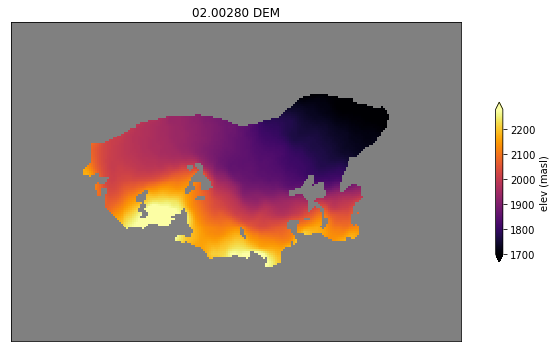

In [7]:
# ===== PROCESS EACH GLACIER =====
# for nglac, glac_idx in enumerate(main_glac_rgi_subset.index.values):
for nglac, glac_idx in enumerate([main_glac_rgi_subset.index.values[0]]):
# for nglac, glac_idx in enumerate([main_glac_rgi_subset.index.values[120]]): # Miage
# for nglac, glac_idx in enumerate([main_glac_rgi_subset.index.values[2307]]): # Ngozumpa

    glac_str = main_glac_rgi_subset.loc[glac_idx,'rgino_str']
    rgiid = main_glac_rgi_subset.loc[glac_idx,'RGIId']
    region = glac_str.split('.')[0]

    if int(region) < 10:
        glac_str_noleadzero = str(int(glac_str.split('.')[0])) + '.' + glac_str.split('.')[1]
    else:
        glac_str_noleadzero = glac_str

    if os.path.exists(debris_prms.hd_fp + debris_prms.hd_fn_sample.replace('XXXX',glac_str_noleadzero)) == False:

        print(nglac, glac_idx, rgiid)

        # Create glacier feature from ice thickness raster
        thick_dir = debris_prms.oggm_fp + 'thickness/RGI60-' + str(region.zfill(2)) + '/'
        thick_fn = 'RGI60-' + str(region.zfill(2)) + '.' + rgiid.split('.')[1] + '_thickness.tif'
        gf = create_glacfeat(thick_dir, thick_fn)
        
        # Debris shape layer processing
        dc_shp_proj_fn = (debris_prms.glac_shp_proj_fp + glac_str + '_dc_crs' + 
                          str(gf.aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
        if os.path.exists(dc_shp_proj_fn) == False:
            dc_shp_init = gpd.read_file(debris_prms.debriscover_fp + debris_prms.debriscover_fn_dict[debris_prms.roi])
            dc_shp_single = dc_shp_init[dc_shp_init['RGIId'] == rgiid]
            dc_shp_single = dc_shp_single.reset_index()
            dc_shp_proj = dc_shp_single.to_crs({'init': 'epsg:' + str(gf.aea_srs.GetAttrValue("AUTHORITY", 1))})
            dc_shp_proj.to_file(dc_shp_proj_fn)
        dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
        dc_shp_lyr = dc_shp_ds.GetLayer()

        # Add layers
        gf.add_layers(dc_shp_lyr, gf_add_dhdt=True, gf_add_vel=True, gf_add_ts=False, gf_add_slope_aspect=True,
                      gf_add_ts_info=False, calc_emergence=True, debug_emergence=False)

        # ===== PLOTS =====
#         # DEM
#         var_full2plot = gf.z1.copy()
#         clim = malib.calcperc(var_full2plot, (2,98))
#         plot_array(var_full2plot, clim, [glac_str + ' DEM'], 'inferno', 'elev (masl)', close_fig=False)
#         # Elevation change
#         var_full2plot = gf.dhdt.copy()
#         clim = malib.calcperc(var_full2plot, (2,98))
#         plot_array(var_full2plot, clim, [glac_str + ' dhdt'], 'inferno', 'dhdt (m/yr)', close_fig=False)
#         # Velocity
#         var_full2plot = (gf.vx.copy()**2 + gf.vy.copy()**2)**0.5
#         clim = malib.calcperc(var_full2plot, (2,98))
#         plot_array(var_full2plot, clim, [glac_str + ' velocity'], 'inferno', 'vel (m/yr)', close_fig=False)
#         # Emergence velocity
#         var_full2plot = gf.emvel.copy()
#         clim = malib.calcperc(var_full2plot, (2,98))
#         plot_array(var_full2plot, clim, [glac_str + ' emvel'], 'inferno', 'emvel (m/yr)', close_fig=False)
#         # Surface temperature
#         var_full2plot = gf.ts.copy()
#         clim = malib.calcperc(var_full2plot, (2,98))
#         plot_array(var_full2plot, clim, [glac_str + ' Ts'], 'inferno', 'ts (degC)', close_fig=False)
        
        # Bin data
        outbins_df, z_bin_edges = gf.hist_plot(bin_width=debris_prms.mb_bin_size)
        # Export binned data
        if int(gf.feat_fn.split('.')[0]) < 10:
            outbins_fullfn = os.path.join(outdir_csv, gf.feat_fn[0:7] + csv_ending)
        else:
            outbins_fullfn = os.path.join(outdir_csv, gf.feat_fn[0:8] + csv_ending)
        outbins_df.loc[:,:] = np.nan_to_num(outbins_df.loc[:,:],0)
        outbins_df.to_csv(outbins_fullfn, index=False)

In [ ]:
print('\n\nDONE!\n\n')

In [ ]:
# ===== SHEAN ESTIMATE OF FLUX DIVERGENCE QUICKLY ======
#                 if gf.H is not None:
#                     #Compute flux
#                     gf.Q = gf.H * debris_prms.v_col_f * np.array([gf.vx, gf.vy])
#                     #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
#                     #Want x-derivative of x component
#                     gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]
# #                     gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
# #                             + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])
#                     #Should smooth divQ, better handling of data gaps

In [ ]:
# ===== OLD CHECK DEM FOR ERRORS AND REPLACE SCRIPT (no longer needed with OGGM processing) =====
#         #Create buffer around glacier polygon
#         glac_geom_buff = gf.glac_geom.Buffer(debris_prms.buff_dist)
#         #This is False over glacier polygon surface, True elsewhere - can be applied directly
#         glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])
        
#             # ds masks
#             ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
#             dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
#             dems_mask = dem1.mask
#             if verbose:
#                 print('list of datasets:', len(ds_list_masked), fn_dict.values())

#             #Combine to identify ~1 km buffer around glacier polygon over static rock
#             static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
#             static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)
        
        
#             # Check if DEM has huge errors or not - replace if necessary
#             if input.roi in ['01']:

#                 gf.z1_check = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
#                 if gf.z1_check.min() < 0:

#                     # Add backup DEM for regions with known poor quality (ex. Alaska)
#                     print('switching DEMs')
#                     fn_dict['z1_backup'] = input.z1_backup_dict[input.roi]
#                     # Warp everything to common res/extent/proj (a second time)
#                     ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
#                             extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
#                             r='cubic')
#                     ds_dict = dict(zip(fn_dict.keys(), ds_list))

#                     if verbose:
#                         print(ds_list)
#                         print(fn_dict.keys())

#                     # ds masks
#                     ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
#                     dem1 = np.ma.masked_less_equal(ds_list_masked[-1], 0)
#                     dems_mask = dem1.mask
#                     if verbose:
#                         print('list of datasets:', len(ds_list_masked), fn_dict.values())

#                     #Combine to identify ~1 km buffer around glacier polygon over static rock
#                     static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
#                     static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

#                     #This is False over glacier polygon surface, True elsewhere - can be applied directly
#                     glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1_backup'])
#                     gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=glac_geom_mask)
#                     #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

#                     # Debris cover
#                     dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
#                     gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=dc_mask)